In [ ]:
!pip install swig
!pip install gymnasium
!pip install gymnasium[box2d]
# !pip install pyvirtualdisplay

In [ ]:
# !apt-get install xvfb

In [ ]:
import gymnasium as gym

import numpy as np
from collections import namedtuple, deque
from itertools import count

import time
import math
import random

import matplotlib
import matplotlib.pyplot as plt
import PIL.Image
# from pyvirtualdisplay import Display

import imageio
from IPython.display import Video, display

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Display(visible=0, size=(840, 480)).start()

In [ ]:
env = gym.make("LunarLander-v2", render_mode="rgb_array")
# env = gym.make("CartPole-v1")

In [ ]:
env.reset()
# PIL.Image.fromarray(env.render())

(array([-0.00177498,  1.409063  , -0.17980209, -0.08253615,  0.00206353,
         0.04072789,  0.        ,  0.        ], dtype=float32),
 {})

In [ ]:
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.memory.append(Transition(state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [ ]:
class DQN(nn.Module):

    def __init__(self, num_states, num_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(num_states, 128)
        self.layer2 = nn.Linear(128, 64)
        self.layer3 = nn.Linear(64, num_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [ ]:
state_size = env.observation_space.shape[0]
num_actions = env.action_space.n

print('Number of observations in each State:', state_size)
print('Number of actions:', num_actions)

Number of observations in each State: 8
Number of actions: 4


In [ ]:
MEMORY_SIZE = 100000      # size of memory buffer
GAMMA = 0.995             # discount factor
ALPHA = 1e-3              # learning rate

BATCH_SIZE = 128
# GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
# LR = 1e-4

In [ ]:
policy_net = DQN(state_size, num_actions).to(device)
target_net = DQN(state_size, num_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

<All keys matched successfully>

In [ ]:
optimizer = optim.AdamW(policy_net.parameters(), lr=ALPHA, amsgrad=True)
memory = ReplayMemory(MEMORY_SIZE)
steps_done = 0

In [ ]:
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

In [ ]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

In [ ]:
start = time.time()

num_episodes = 500
max_num_timesteps = 1000
NUM_STEPS_FOR_UPDATE = 4  # perform a learning update every C time steps

total_reward_history = []
average_count = num_episodes//10    # display the average reward of the past average_count episodes

# if torch.cuda.is_available():
#     num_episodes = 100
# else:
#     num_episodes = 100


for episode in range(num_episodes):
    total_reward = 0
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

    for t in range(max_num_timesteps):
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())

        total_reward += reward

        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, reward, next_state, done)

        # Move to the next state
        state = next_state

        # if t %  == NUM_STEPS_FOR_UPDATE:
        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            break

    total_reward_history.append(total_reward)
    av_latest_rewards = np.mean(total_reward_history[-average_count:])

    print(f"\rEpisode {episode+1:3} | Average reward of the last {average_count} episodes: {av_latest_rewards:.2f}   episode reward: {total_reward:.2f}", end=" ")

    if (episode+1) % average_count == 0:
        print(f"\rEpisode {episode+1:3} | Average reward of the last {average_count} episodes: {av_latest_rewards:.2f}")

    # We will consider that the environment is solved if we get an
    # average of 200 points in the last 100 episodes.
    # if av_latest_points >= 200.0:
    #     print(f"\n\nEnvironment solved in {i+1} episodes!")
    #     q_network.save('lunar_lander_model.h5')
    #     break

tot_time = time.time() - start

print(f"\nTotal Runtime: {tot_time:.2f} s ({(tot_time/60):.2f} min)")
print('Complete')


Episode  50 | Average reward of the last 50 episodes: 35.19
Episode 100 | Average reward of the last 50 episodes: 179.45
Episode 150 | Average reward of the last 50 episodes: 25.77
Episode 200 | Average reward of the last 50 episodes: -15.22
Episode 250 | Average reward of the last 50 episodes: 56.95
Episode 300 | Average reward of the last 50 episodes: 172.18
Episode 350 | Average reward of the last 50 episodes: 253.08
Episode 400 | Average reward of the last 50 episodes: 193.26
Episode 450 | Average reward of the last 50 episodes: 250.20
Episode 500 | Average reward of the last 50 episodes: 227.25

Total Runtime: 1400.90 s (23.35 min)
Complete


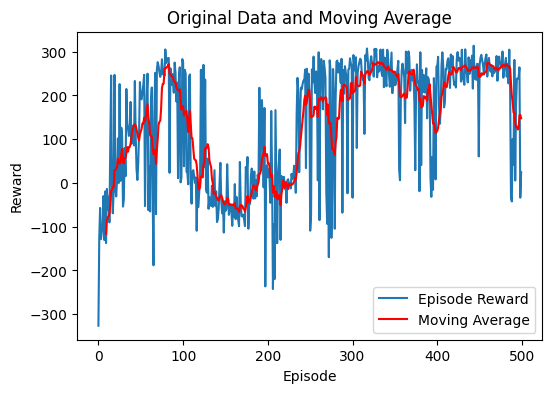

In [ ]:
# Function to calculate the moving average
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size), 'valid') / window_size


data = total_reward_history
window_size = 10  # Change this to the desired window size for moving average
moving_avg = moving_average(data, window_size)

plt.figure(figsize=(6, 4))
plt.plot(data, label='Episode Reward')
plt.plot(range(window_size - 1, len(data)), moving_avg, color='red', label='Moving Average')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Original Data and Moving Average')
plt.legend()
plt.show()

In [ ]:
# policy_net = DQN(state_size, num_actions).to(device)
# target_net = DQN(state_size, num_actions).to(device)

# policy_net.load_state_dict(torch.load('policy_net.pt'))
# target_net.load_state_dict(torch.load('target_net.pt'))

In [ ]:
def run_and_record(env_name, model, video_path='dqn_run.mp4'):
    test_env = gym.make(env_name, render_mode="rgb_array")
    state, info = test_env.reset()
    done = False

    with imageio.get_writer(video_path, fps=30) as video:
        while not done:

            # state = torch.FloatTensor(state).unsqueeze(0)
            state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
            with torch.no_grad():
                action = torch.argmax(model(state))
            # next_state, _, done, _ = env.step(action)

            observation, reward, terminated, truncated, _ = test_env.step(action.item())
            done = terminated or truncated

            if terminated:
                next_state = None
            else:
                next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

            video.append_data(test_env.render())
            state = next_state

    test_env.close()
    return video_path

# Run the environment and record the video
env_name = 'LunarLander-v2'  # Replace with your environment
video_path = run_and_record(env_name, policy_net)

# Display the video in the notebook
display(Video(video_path, embed=True))


<ipython-input-95-cb01e3747e0e>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)


In [ ]:
import os
from gymnasium.wrappers import RecordVideo
from IPython.display import Video

video_folder = 'runs'
video_name = 'dqn_run'

record_env = RecordVideo(env, video_folder, name_prefix=video_name)
state, info = env.reset()
done = False

record_env.start_video_recorder()

while not done:
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    with torch.no_grad():
        action = torch.argmax(policy_net(state)).item()
        # action = policy_net(state).max(1)[1].view(1, 1).item(0)

    observation, reward, terminated, truncated, _ = record_env.step(action)
    done = terminated or truncated

    if done:
        next_state = None
    else:
        next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
    state = next_state

record_env.close_video_recorder()
record_env.close()

# video_path = os.path.join(video_folder, f"{video_name}.mp4")
video_path = 'runs/dqn_run-episode-0.mp4'

# Display the video in the notebook
display(Video('runs/dqn_run-episode-0.mp4', embed=True))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /content/runs folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
<ipython-input-98-0ec41a00dc3e>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)


Moviepy - Building video /content/runs/dqn_run-episode-0.mp4.
Moviepy - Writing video /content/runs/dqn_run-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/runs/dqn_run-episode-0.mp4


In [ ]:
display(Video('runs/dqn_run-episode-0.mp4', embed=True))

In [ ]:
torch.save(policy_net.state_dict(), 'policy_net.pt')
torch.save(target_net.state_dict(), 'target_net.pt')